In [ ]:
import pandas as pd
from socube.train import evaluateReport
from socube.utils import writeCsv, log, mkDirs

def ensemble(files:list):
    data = [pd.read_csv(file, header=None) for file in files ]
    return sum(data)/len(data)

def concencate(filenameFormat:str, start:int, end:int):
    columns = list(range(start, end+1))
    datas = [pd.read_csv(filenameFormat%idx, index_col=0) for idx in columns]
    datas.append(sum(datas)/len(datas))
    columns.append("mean")
    try:
        datas.append(pd.read_csv(filenameFormat%"Bagging", index_col=0))
        columns.append("Bagging")
    finally:
        datas = pd.concat(datas, axis=1)
        datas.columns = columns
        datas.index.name = "指标"
        return datas

In [ ]:
dataType="nuc-MULTI"
modelID="20220115-150149-915"
fold=5
threshold = 0.5

score = ensemble(f"outputs/{dataType}/{modelID}/test_score_{i+1}.csv" for i in range(fold))[0].values
label = pd.read_csv(f"datasets/{dataType}/ExperimentLabel.csv", header=None, index_col=0)[1].values

mkDirs(f"plots/{dataType}/{modelID}")
mkDirs(f"outputs/{dataType}/{modelID}")

log("inference", "Evaluating...")
report=evaluateReport(
        label, 
        score, 
        f"plots/{dataType}/{modelID}/test_roc_Bagging_{threshold}.png", 
        f"plots/{dataType}/{modelID}/test_prc_Bagging_{threshold}.png",
        threshold=threshold)
writeCsv(report, f"outputs/{dataType}/{modelID}/test_report_Bagging_{threshold}.csv")
writeCsv(score, f"outputs/{dataType}/{modelID}/test_score_Bagging.csv")
log("inference", "Finished...")
report

In [ ]:
val = concencate(f"outputs/{dataType}/{modelID}/test_report_%s_0.5.csv", 1, fold)
val.to_clipboard()
val

In [ ]:
import pandas as pd
import sklearn.metrics as metrics
import numpy as np

from socube.train import binaryRate

In [ ]:
def calPRT(
    dataset:str,
    modelID:str,
    idRate = 0.1,
    fold:int = 5):
    label = pd.read_csv(f"datasets/{dataset}/ExperimentLabel.csv", index_col=0, header=None).values.flatten()
    data = pd.DataFrame(dtype="float32", columns=["precision", "recall", "TNR"])
    for idx in range(1, fold + 1):
        score = pd.read_csv(f"outputs/{dataset}/{modelID}/test_score_{idx}.csv", header=None).values.flatten()
        k = int(idRate * len(score))
        r = len(score)-k
        theshold = np.partition(score, r)[r]
        predict = (score>=theshold).astype("int16")
        assert k == predict.sum().item()

        precision = metrics.precision_score(label, predict)
        recall = metrics.recall_score(label, predict)
        tpr,fnr,fpr,tnr = binaryRate(label, predict)
        data = data.append(pd.Series({
            "precision": precision,
            "recall": recall,
            "TNR": tnr,
            "TPR": tpr,
            "FNR": fnr,
            "FPR": fpr
        }, name=idx))
    
    mean = data.mean()
    mean.name = "mean"
    data = data.append(mean)
    return data

In [ ]:
calPRT(
    dataset= "pbmc-1A-dm",
    modelID= "20220221-175223-147"
)

## 特征可视化

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath("src"))

import torch
import numpy as np
import pandas as pd
from socube.task.doublet import SoCubeNet, ConvClassifyDataset
from socube.utils import autoClearIter, loadTorchModule, writeCsv, writeNpy
from socube.data import umap2D, plotScatter
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from typing import List, Union
from glob import glob
from scipy.stats import entropy
from socube.cube import SoCube

c:\Users\zhang\anaconda3\envs\socube_test\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
@torch.no_grad()
def getLatent(dataType:str, socubeId:str, netId:str, dataDir:str)->List[Union[np.ndarray, pd.DataFrame]]:
    dataset = ConvClassifyDataset(
        data_dir= os.path.join("internal_datasets",dataType, socubeId, dataDir),
        labels="ExperimentLabel.csv",
        shuffle=True,
        seed=4067,
        use_index=False
    )

    dataLoader = DataLoader(
        dataset=dataset,
        batch_size=400
    )
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = SoCubeNet(len(dataset[0]["data"]), 2 , binary=True).to(device)
    model =loadTorchModule(model, f"internal_models/{dataType}/{netId}/{SoCubeNet.__name__}_1.pt", skipped=False)
    itererate = autoClearIter(dataLoader)
    itererate = tqdm(itererate, desc="Validate")

    latents = []
    #labels = []
    for batch in itererate:
        data, label = batch.values()
        data = data.to(device)
        label = label.to(device)
        latent = model._feature(data)
        latents.append(latent)
        del data, label, latent

    latents = torch.cat(latents)
    #labels = torch.cat(labels)
    return latents.cpu().numpy(), dataset._labels

def getKL(data:pd.DataFrame, seed:int=None):
    mins = data.loc[:,"x":"y"].min()

    p = data[data.subtype=='doublet'].loc[:,"x":"y"]-mins + 1e-7
    q = data[data.subtype=='singlet'].loc[:,"x":"y"]-mins + 1e-7
    if len(p) > len(q):
        p, q = q, p
    q = q.sample(len(p), random_state=seed)
    
    return entropy(p.x, q.x), entropy(p.y, q.y)
    # data = data[data.subtypes=='doublet'].loc[:,"x":"y"]
    # return (data.std()/data.mean()).sum()

def getDistance(data:pd.DataFrame):
    doublet = data[data.subtype=='doublet'].loc[:,"x":"y"].mean()
    singlet = data[data.subtype=='singlet'].loc[:,"x":"y"].mean()
    return np.sqrt(np.square((singlet-doublet)/singlet).sum())


In [3]:
dataset = "pbmc-1A-dm"
modelID = "20220314-163907-189"
cubeID = pd.read_csv(glob(f"internal_outputs/{dataset}/{modelID}/*_aveReport.csv")[0], index_col=0, header=None)
dataDir = cubeID.loc["data_dir"][1]
try:
    cubeID = cubeID.loc["socube"][1]
except KeyError as e:
    try:
        cubeID = cubeID.loc["scomap"][1]
    except KeyError as e:
        cubeID = dataDir.split("/")[-2]

dataDir = os.path.basename(dataDir)
metric="cosine"
typeMap = ["singlet", "doublet"]
print(cubeID)
print(dataDir)

20220115-174928-553
data[float32][raw+samples(1)+log+std+mmn]


In [7]:
latents, labels = getLatent(
    dataType=dataset,
    socubeId=cubeID,
    netId=modelID,
    dataDir=dataDir)

2022-07-04 18:52:19,785 - loadTorchModule - INFO - model internal_models/pbmc-1C-dm/20220702-130505-840/SoCubeNet_1.pt loaded
Validate: 14it [02:31, 10.80s/it]


socube编码和特征提取后，doublet逐渐聚集，并与singlet呈现剥离趋势

In [4]:
# writeNpy(latents, f"internal_outputs/{dataset}/{modelID}/latent_1.npy")

# latents2D = umap2D(pd.DataFrame(latents, index=labels.index), metric=metric)
# latents2D.index.name = "droplet"
# writeCsv(latents2D.loc[:,"x":"y"],  f"internal_outputs/{dataset}/{modelID}/latent_1_umap2D_{metric}.csv")
latents2D=pd.read_csv(f"internal_outputs/{dataset}/{modelID}/latent_1_umap2D_{metric}.csv", index_col=0)
labels=pd.read_csv(f"internal_datasets/{dataset}/ExperimentLabel.csv", index_col=0, header=None)

latents2D["label"] = latents2D.index
latents2D["subtype"] = labels[1].apply(lambda x: typeMap[x])
getDistance(latents2D)

2.217089770614848

In [35]:
plotScatter(
    data2d=latents2D,
    colormap={
        "singlet":"#E6E6FA",
        "doublet":"#39547F"
        
    },
    title="Latent feature visualization",
    subtitle="By socube",
    scatter_symbol="circle",
    filename=f"internal_plots/{dataset}/{modelID}/latent_{metric}_1",
    radius=4,
    # xMin=-5,
    # xMax=15,
    # yMin=-6,
    # yMax=14,
    x_title="UMAP_1",
    y_title="UMAP_2"
)

2022-07-04 20:48:17,506 - socube.data.visualize - INFO - Save to internal_plots/pbmc-1A-dm/20220314-163907-189/latent_cosine_1.html


In [18]:
predictScore = pd.read_csv(f"outputs/{dataType}/{netId}/test_score_Bagging.csv", header=None)
# predictScore=pd.read_clipboard(index_col=0)
latents2D_predict = pd.read_csv(f"outputs/{dataType}/{netId}/latent_1_umap2D_{metric}.csv")
latents2D_predict["subtype"]=predictScore.iloc[:,0].values
latents2D_predict["label"]=latents2D_predict["subtype"]

In [15]:
plotScatter(
    data2d=latents2D_predict,
    colormap={
        "doublet":"#39547F",
        "singlet":"#E48373"
        
    },
    title="Latent feature visualization",
    subtitle="By socube",
    filename=f"plots/{dataType}/{netId}/latent_{metric}_1_predict",
    radius=3,
    # xMin=-5,
    # xMax=15,
    # yMin=-6,
    # yMax=14,
    xTitle="UMAP_1",
    yTitle="UMAP_2"
)

NameError: name 'latents2D_predict' is not defined

In [25]:
# rawData = pd.read_hdf(f"datasets/{dataType}/02-trainData[int16][raw+samples(1)].h5")
# rawData = rawData[rawData.apply(lambda x: not x.name.startswith("doublet"), axis=1)]
# raw2D = umap2D(rawData, metric=metric)
# writeCsv(raw2D.loc[:,"x":"y"],  f"outputs/{dataType}/{netId}/raw_umap2D_{metric}.csv")
raw2D=pd.read_csv(f"internal_outputs/{dataset}/{modelID}/raw_umap2D_{metric}.csv", index_col=0)
raw2D["label"]=raw2D.index
raw2D["subtype"]=latents2D["subtype"]
# getKL(raw2D)
getDistance(raw2D)

0.045572787124727517

In [36]:
plotScatter(
    data2d=raw2D,
    colormap={
        "singlet":"#E6E6FA",
        "doublet":"#39547F"
        
    },
    title="Latent feature visualization",
    subtitle="Raw data",
    scatter_symbol="circle",
    radius=4,
    filename=f"internal_plots/{dataset}/{modelID}/raw_{metric}",
    x_title="UMAP_1",
    y_title="UMAP_2"
)

2022-07-04 20:48:24,742 - socube.data.visualize - INFO - Save to internal_plots/pbmc-1A-dm/20220314-163907-189/raw_cosine.html


## df可视化

In [29]:
from socube.train import evaluateReport
dir=f"internal_outputs/solo_result/results_{dataset}[csc_sparse_matrix].h5ad_2020"
sololatent = np.load(f"{dir}/latent.npy")
soloscore = np.load(f"{dir}/softmax_scores.npy")
sololabel = pd.read_csv(f"internal_datasets/{dataset}/ExperimentLabel.csv", index_col=0, header=None)
sololatent = pd.DataFrame(sololatent, index=sololabel.index)
# sololatent2D = umap2D(sololatent, metric=metric)
# writeCsv(sololatent2D.loc[:,"x":"y"],  f"{dir}/latent_umap2D_{metric}.csv")
sololatent2D = pd.read_csv(f"{dir}/latent_umap2D_{metric}.csv", index_col=0)
sololatent2D["label"]=sololatent2D.index
sololatent2D["subtype"]=sololabel[1].apply(lambda x: typeMap[x])

In [37]:
plotScatter(
    data2d=sololatent2D,
    colormap={
        "singlet":"#E6E6FA",
        "doublet":"#39547F"
        
    },
    title="Latent feature visualization",
    subtitle="By Solo",
    scatter_symbol="circle",
    radius=4,
    filename=f"{dir}/latent_umap2D_{metric}",
    # xMin=-5,
    # xMax=15,
    # yMin=-6,
    # yMax=14,
    x_title="UMAP_1",
    y_title="UMAP_2"
)

2022-07-04 20:48:28,548 - socube.data.visualize - INFO - Save to internal_outputs/solo_result/results_pbmc-1A-dm[csc_sparse_matrix].h5ad_2020/latent_umap2D_cosine.html


In [24]:
# getKL(sololatent2D)
getDistance(sololatent2D)

0.6672835519385356

In [25]:
# predictScore=pd.read_clipboard(index_col=0)
latents2D_solopredict = pd.read_csv(f"outputs/{dataType}/{netId}/latent_1_umap2D_{metric}.csv")
latents2D_solopredict["subtype"]=soloscore
latents2D_solopredict["label"]=latents2D_solopredict["subtype"]

In [26]:
plotScatter(
    data2d=latents2D_solopredict,
    colormap={
        "doublet":"#39547F",
        "singlet":"#E48373"

        
    },
    title="Latent feature visualization",
    subtitle="By Solo",
    filename=f"{dir}/predict_umap2D_{metric}",
    radius=3,
    # xMin=-5,
    # xMax=15,
    # yMin=-6,
    # yMax=14,
    xTitle="UMAP_1",
    yTitle="UMAP_2"
)

2022-05-30 17:05:36,304 - socube.data.visualize - INFO - Save to outputs/solo_result/results_pbmc-1C-dm[csc_sparse_matrix].h5ad_2020/predict_umap2D_cosine.html


## DoubletFinder可视化

In [27]:
dir="outputs/doubletfinder_result"
for scorefile in glob(f"{dir}/{dataType}.*csv"):
    dfscore = pd.read_csv(scorefile, index_col=0)
    dflabel = pd.read_csv(f"datasets/{dataType}/ExperimentLabel.csv", index_col=0, header=None)

In [28]:
dfscore[dfscore.score>=0.5]

score
AAACCGTGGCATCA-1  0.828571
AAACGCACGTTGCA-1  0.742857
AAACGGCTCTCAAG-1  0.685714
AAACTTGATGGTTG-1  0.514286
AAATGGGATTAGGC-1  0.885714
...                    ...
TTGGAGTGCATGCA-1  0.685714
TTGGGAACTCAGAC-1  0.685714
TTGTACACACGCAT-1  0.742857
TTTAGAGAGCAGAG-1  0.571429
TTTCCAGATGCGTA-1  0.542857

[303 rows x 1 columns]

In [29]:
# predictScore=pd.read_clipboard(index_col=0)
latents2D_dfpredict = pd.read_csv(f"outputs/{dataType}/{netId}/latent_1_umap2D_{metric}.csv")
latents2D_dfpredict["subtype"]=dfscore["score"].values
latents2D_dfpredict["label"]=latents2D_dfpredict["subtype"]
plotScatter(
    data2d=latents2D_dfpredict,
    colormap={
        "doublet":"#39547F",
        "singlet":"#E48373"
        
    },
    title="Latent feature visualization",
    subtitle="By DoubletFinder",
    filename=f"{dir}/predict_{dataType}_umap2D_{metric}",
    radius=3,
    # xMin=-5,
    # xMax=15,
    # yMin=-6,
    # yMax=14,
    xTitle="UMAP_1",
    yTitle="UMAP_2"
)

2022-05-30 17:06:20,303 - socube.data.visualize - INFO - Save to outputs/doubletfinder_result/predict_pbmc-1C-dm_umap2D_cosine.html


### Cluster

In [ ]:
import pandas as pd
import numpy as np
from socube.utils import writeHdf
from socube.data import umap2D, plotScatter
from anndata import read_h5ad
from scipy.sparse import issparse

In [ ]:
data = read_h5ad("datasets/sim_DE_8/sim_DE_8.h5ad")
label = data.obs
data = pd.DataFrame(
    data.X.toarray() if issparse(data.X) else data.X, 
    columns = data.var_names, 
    index = data.obs_names)

data = data[label["type"] == "singlet"]

In [ ]:
data2d = umap2D(data)

In [ ]:
writeHdf(data2d, "datasets/sim_DE_8/sim_DE_8_umap2D[clean].h5")

In [ ]:
data2d["subtype"] = "singlet"
data2d["label"] = "singlet"

In [ ]:
plotScatter(
    data2d=data2d,
    colormap={
        "doublet":"#39547F",
        "singlet":"#E48373"
        
    },
    title="Clean data cluster result",
    subtitle="By DoubletFinder",
    filename=f"plots/sim_DE_8/cluster",
    radius=3,
    # xMin=-5,
    # xMax=15,
    # yMin=-6,
    # yMax=14,
    xTitle="UMAP_1",
    yTitle="UMAP_2"
)

In [ ]:
socube_cluster = pd.read_csv("outputs/sim_DE_8/20220412-203606-607/cluster.csv", index_col=0)
socube_cluster.index = socube_cluster.apply(lambda x: str(x.name), axis=1)
data2d_socube = data2d.join(socube_cluster)
data2d_socube["subtype"] = data2d_socube["cluster"].apply(lambda x: "cluster-%s"%(x))
data2d_socube = data2d_socube.drop("cluster", axis=1)
data2d_socube["label"] = data2d_socube["subtype"]

In [ ]:
plotScatter(
    data2d=data2d_socube,
    colormap={
        "cluster-0.0":"#ff0000",
        "cluster-1.0":"#00ff00",
        "cluster-2.0":"#0000ff",
        "cluster-3.0":"#393939",
        "cluster-4.0":"#E483E4",
        "cluster-5.0":"#838383",
        "cluster-6.0":"#005479",
        "cluster-7.0":"#008370",
        "cluster-8.0":"#558371",
    },
    title="Latent feature visualization",
    subtitle="By SoCube",
    filename=f"plots/sim_DE_8/20220412-203606-607/cluster",
    radius=3,
    # xMin=-5,
    # xMax=15,
    # yMin=-6,
    # yMax=14,
    xTitle="UMAP_1",
    yTitle="UMAP_2"
)

In [ ]:
solo_cluster = pd.read_csv("outputs/solo_result/sim_DE_8_2010/cluster.csv", index_col=0)
solo_cluster.index = solo_cluster.apply(lambda x: str(x.name), axis=1)
data2d_solo = data2d.join(solo_cluster)
data2d_solo["subtype"] = data2d_solo["cluster"].apply(lambda x: "cluster-%s"%(x))
data2d_solo = data2d_solo.drop("cluster", axis=1)
data2d_solo["label"] = data2d_solo["subtype"]

In [ ]:
plotScatter(
    data2d=data2d_solo,
    colormap={
        "cluster-0.0":"#ff0000",
        "cluster-1.0":"#00ff00",
        "cluster-2.0":"#0000ff",
        "cluster-3.0":"#393939",
        "cluster-4.0":"#E483E4",
        "cluster-5.0":"#838383",
        "cluster-6.0":"#005479",
        "cluster-7.0":"#008370",
        "cluster-8.0":"#558371",
    },
    title="Latent feature visualization",
    subtitle="By SoCube",
    filename=f"plots/solo_result/sim_DE_8_cluster",
    radius=3,
    # xMin=-5,
    # xMax=15,
    # yMin=-6,
    # yMax=14,
    xTitle="UMAP_1",
    yTitle="UMAP_2"
)

In [ ]:
df_cluster = pd.read_csv("outputs/doubletfinder_result/sim_DE_8/cluster.csv", index_col=0)
df_cluster.index = df_cluster.apply(lambda x: str(x.name), axis=1)
data2d_df = data2d.join(df_cluster)
data2d_df["subtype"] = data2d_df["cluster"].apply(lambda x: "cluster-%s"%(x))
data2d_df = data2d_df.drop("cluster", axis=1)
data2d_df["label"] = data2d_df["subtype"]

In [ ]:
data2d_df["subtype"].value_counts()

In [ ]:
plotScatter(
    data2d=data2d_df,
    colormap={
        "cluster-0":"#ff0000",
        "cluster-1":"#00ff00",
        "cluster-2":"#0000ff",
        "cluster-3":"#393939",
        "cluster-4":"#E483E4",
        "cluster-5":"#838383",
        "cluster-6":"#005479",
        "cluster-7":"#008370",
        "cluster-8":"#558371",
    },
    title="Latent feature visualization",
    subtitle="By DoubletFinder",
    filename=f"plots/doubletfinder_result/sim_DE_8/cluster",
    radius=3,
    # xMin=-5,
    # xMax=15,
    # yMin=-6,
    # yMax=14,
    xTitle="UMAP_1",
    yTitle="UMAP_2"
)

In [ ]:
data = read_h5ad("datasets/sim_DE_8/sim_DE_8.h5ad")
label = data.obs
data = pd.DataFrame(
    data.X.toarray() if issparse(data.X) else data.X, 
    columns = data.var_names, 
    index = data.obs_names)


In [ ]:
socube_score = pd.read_csv("outputs/sim_DE_8/20220412-203606-607/test_score_Bagging.csv", header=None)[0].values
threshold = socube_score[np.argpartition(socube_score, len(socube_score) - 800)[len(socube_score) - 800]]
socube_data = data[socube_score < threshold]
socube_data2d = umap2D(socube_data)
socube_data2d["subtype"] = "singlet"
socube_data2d["label"] = "singlet"

In [ ]:
plotScatter(
    data2d=socube_data2d,
    colormap={
        "doublet":"#39547F",
        "singlet":"#E48373"
        
    },
    title="Latent feature visualization",
    subtitle="By Socube",
    filename=f"plots/sim_DE_8/20220412-203606-607/cluster_raw",
    radius=3,
    # xMin=-5,
    # xMax=15,
    # yMin=-6,
    # yMax=14,
    xTitle="UMAP_1",
    yTitle="UMAP_2"
)

In [ ]:
df_score = pd.read_csv("outputs/doubletfinder_result/sim_DE_8/sorce.csv", index_col=0)["x"].values < 0.5
df_data = data[df_score]
df_data2d = umap2D(df_data)
df_data2d["subtype"] = "singlet"
df_data2d["label"] = "singlet"

In [ ]:
plotScatter(
    data2d=df_data2d,
    colormap={
        "doublet":"#39547F",
        "singlet":"#E48373"
        
    },
    title="Latent feature visualization",
    subtitle="By Socube",
    filename=f"plots/doubletfinder_result/sim_DE_8/cluster_raw",
    radius=3,
    # xMin=-5,
    # xMax=15,
    # yMin=-6,
    # yMax=14,
    xTitle="UMAP_1",
    yTitle="UMAP_2"
)

## jaccard index计算

In [1]:
import pandas as pd

In [52]:
def create_cell_pairs(data: pd.DataFrame) -> set:
    cell_pairs = set()
    for name in data.iloc[:,0].unique():
        subType = data[data.iloc[:, 0] == name].index
        for i in range(len(subType) - 1):
            for j in range(i, len(subType)):
                cell_pair = "_".join(sorted([subType[i], subType[j]]))
                cell_pairs.add(cell_pair)
    return cell_pairs

def jaccard(data1: set, data2: set)->float:
    Intersection = len(data1.intersection(data2))
    return Intersection/(len(data1) + len(data2) - Intersection)

In [62]:
cell_type = pd.read_csv("datasets/scPred_pbmc_1/cellType.csv", index_col=0)
cell_type_pairs = create_cell_pairs(cell_type)
cell_cluster_clean = pd.read_csv(r"outputs\scPred_pbmc_1\clean_cluster.csv", index_col=0)
cell_cluster_clean_pairs = create_cell_pairs(cell_cluster_clean)
print("Jaccard index of Control compared with true type", jaccard(cell_type_pairs, cell_cluster_clean_pairs))
cell_cluster_socube = pd.read_csv("outputs/scPred_pbmc_1/20220416-172623-141/cluster.csv", index_col=0)
cell_cluster_socube_pairs = create_cell_pairs(cell_cluster_socube)
print("Jaccard index of SoCube compared with true type", jaccard(cell_type_pairs, cell_cluster_socube_pairs))
print("Jaccard index of SoCube compared with Control", jaccard(cell_cluster_clean_pairs, cell_cluster_socube_pairs))
cell_cluster_solo = pd.read_csv(r"outputs\solo_result\scPred_pbmc_1_2010\cluster.csv", index_col=0)
cell_cluster_solo_pairs = create_cell_pairs(cell_cluster_solo)
print("Jaccard index of Solo compared with true type", jaccard(cell_cluster_solo_pairs, cell_type_pairs))
print("Jaccard index of Solo compared with Control", jaccard(cell_cluster_clean_pairs, cell_cluster_solo_pairs))
cell_cluster_df = pd.read_csv(r"outputs\doubletfinder_result\scPred_pbmc_1\cluster.csv", index_col=0)
cell_cluster_df_pairs = create_cell_pairs(cell_cluster_df)
print("Jaccard index of DF compared with true type", jaccard(cell_type_pairs, cell_cluster_df_pairs))
print("Jaccard index of DF compared with Control", jaccard(cell_cluster_clean_pairs, cell_cluster_df_pairs))

Jaccard index of Control compared with true type 0.26352044281359527
Jaccard index of SoCube compared with true type 0.2575289083617617
Jaccard index of SoCube compared with Control 0.5257199168120581
Jaccard index of Solo compared with true type 0.2247117287513533
Jaccard index of Solo compared with Control 0.4373174858764772
Jaccard index of DF compared with true type 0.20283437073784627
Jaccard index of DF compared with Control 0.39727718563509834


## scWGCNA计算

In [1]:
import pandas as pd

from buildSoCube import build
from socube.data import plotGrid

In [18]:
dataset = "pbmc-1A-dm"
socubeId = "20220115-174928-553"
_, cube = build(dataset, socubeId)
co_gene = pd.read_csv(f"outputs/{dataset}/co-expression-gene[{socubeId}].csv", index_col=0)
grid = cube.grid.join(co_gene)
grid["module"].fillna("other", inplace=True)
grid["label"] = grid.index
grid.columns = ["x", "y", "subtype", "label"]
plotGrid(
    data2d=grid,
    colormap={
        "module_1": "#DB7093",
        "module_4": "#9370DB",
        "module_3": "#6A5ACD",
        "module_2": "#F0FFFF",
        "module_5": " #FFDEAD",
        "other": "#F8F8FF"
    },
    shape=cube.shape,
    title=f"WGCNA on {dataset}",
    subtitle="UMAP based",
    filename=f"plots/{dataset}/WGCNA[{socubeId}]"
)

2022-05-24 22:24:47,810 - ParalManager - INFO - Enter a multi-thread context
2022-05-24 22:24:47,833 - ParalManager - INFO - Wait for 0 asynchronou task(s) finished


Training socube...
Load default socube...


2022-05-24 22:24:47,854 - socube.data.visualize - INFO - Save to plots/pbmc-1A-dm/WGCNA[20220115-174928-553].html


## library size区分

In [1]:
import pandas as pd
import numpy as np
from socube.train import evaluateReport
from anndata import read_h5ad
from glob import glob

c:\Users\zhang\anaconda3\envs\socube_test\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
dataset = "pbmc-1C-dm"
modelID = "20220702-130505-840"
cubeID = pd.read_csv(glob(f"internal_outputs/{dataset}/{modelID}/*_aveReport.csv")[0], index_col=0, header=None)
try:
    cubeID = cubeID.loc["socube"][1]
except KeyError as e:
    try:
        cubeID = cubeID.loc["scomap"][1]
    except KeyError as e:
        cubeID = cubeID.loc["data_dir"][1].split("/")[-2]

socube_score= pd.read_csv(f"internal_outputs/{dataset}/{modelID}/final_result_0.5.csv")["predict_score"].values
solo_score = np.load(f"internal_outputs/solo_result/results_{dataset}[csc_sparse_matrix].h5ad_2020/softmax_scores.npy")
df_score = pd.read_csv(glob(f"internal_outputs/doubletfinder_result/{dataset}.rds_score*.csv")[0], index_col=0)["score"].values
result = pd.read_csv(f"internal_datasets/{dataset}/ExperimentLabel.csv", index_col=0, header=None)
assert len(result) == len(socube_score)
result["socube"] = socube_score
result["solo"] = solo_score
result["df"] = df_score
result.columns = ["label", "socube", "solo", "df"]
result.index.name = "gene"
data = read_h5ad(f"internal_datasets/PMID33338399/real_datasets[csc_sparse_matrix]/real_datasets/{dataset}[csc_sparse_matrix].h5ad")
result["size"] = pd.DataFrame(data.X.sum(axis=1))[0].values
result = result.sort_values("size")
del data, socube_score, solo_score, df_score

In [10]:
def split(data: pd.DataFrame, nums: int) -> pd.DataFrame:
    epoch_size = int(np.around(len(data) / nums))
    start_index = 0
    for epoch in range(nums):
        res = (data.iloc[start_index : start_index + epoch_size] if epoch < nums -1  else data.iloc[start_index:]).copy()
        start_index += epoch_size
        yield res

c:\Users\zhang\anaconda3\envs\socube_test\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zhang\anaconda3\envs\socube_test\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zhang\anaconda3\envs\socube_test\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\U

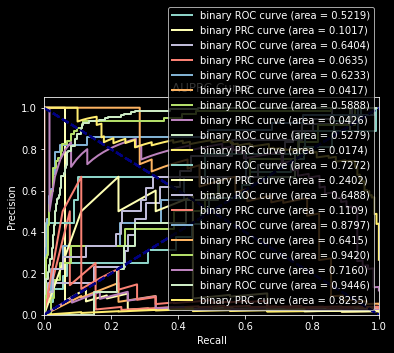

In [11]:
data = pd.DataFrame()
for sub in split(result, 10):
    data = data.append(
        evaluateReport(sub["label"].values, sub["socube"].values)
        , ignore_index=True)
data.to_csv(f"internal_outputs/{dataset}/{modelID}/report_by_szie.csv")

# data = pd.DataFrame()
# for sub in split(result, 10):
#     data = data.append(
#         evaluateReport(sub["label"].values, sub["solo"].values)
#         , ignore_index=True)
# data.to_csv(f"outputs/solo_result/{dataset}_report_by_szie.csv")

# data = pd.DataFrame()
# for sub in split(result, 10):
#     data = data.append(
#         evaluateReport(sub["label"].values, sub["df"].values)
#         , ignore_index=True)
# data.to_csv(f"outputs/doubletfinder_result/{dataset}_report_by_szie.csv")

# 记录提取整理

In [1]:
%cd ..

d:\life_matters\IDRB\深度组学\单细胞组学\SoCube


In [18]:
import pandas as pd

def getCubeId(dataType: str, netID: str) -> str:
    report = pd.read_csv(f"internal_outputs/{dataType}/{netID}/Conv2DClassifyNet_aveReport.csv", header=None, index_col=0)
    try:
        return report.loc["socube"][1]
    except KeyError:
        return report.loc["scomap"][1]

In [19]:
data = pd.read_clipboard()

In [20]:
data

Dataset                netID  CubeID  \
0                                    pbmc-ch  20220113-180008-152     NaN   
1                                   cline-ch  20220313-051423-386     NaN   
2                                 mkidney-ch  20220313-061616-949     NaN   
3                                 pbmc-1A-dm  20220314-163907-189     NaN   
4                                 pbmc-1B-dm  20220313-002301-304     NaN   
5                                 pbmc-1C-dm  20220314-171729-555     NaN   
6                              pbmc-2ctrl-dm  20220314-162706-113     NaN   
7                              pbmc-2stim-dm  20220313-005553-685     NaN   
8                                   J293t-dm  20220313-000955-581     NaN   
9                                  pdx-MULTI  20220312-223936-683     NaN   
10                           HMEC-orig-MULTI  20220313-015830-683     NaN   
11                            HMEC-rep-MULTI  20220313-084432-701     NaN   
12                            HEK-HMEC-MULTI  20220312-213828-624     NaN   
13                                 nuc-MULTI  20220312-235311-551     NaN   
14                                    sim_DE  20220324-221950-309     NaN   
15                             scPred_pbmc_1  20220416-172623-141     NaN   
16                             scPred_pbmc_2  20220416-171845-445     NaN   
17  sim_psudotime_temporally_expressed_genes  20220331-162025-965     NaN   
18                sim_psudotime_3_sequential  20220330-220112-142     NaN   
19                 sim_psudotime_bifurcating  20220329-154456-737     NaN   

                         Task  
0         real benchmark test  
1         real benchmark test  
2         real benchmark test  
3         real benchmark test  
4         real benchmark test  
5         real benchmark test  
6         real benchmark test  
7         real benchmark test  
8         real benchmark test  
9         real benchmark test  
10        real benchmark test  
11        real benchmark test  
12        real benchmark test  
13        real benchmark test  
14               DEG analysis  
15            Cell clustering  
16            Cell clustering  
17    Temporally DEG analysis  
18  Cell trajectory inference  
19  Cell trajectory inference

In [21]:
data["CubeID"] = data.apply(lambda x: getCubeId(x["Dataset"], x["netID"]), axis=1)

In [24]:
data.to_clipboard(index=False)

In [40]:
import re
import os
def isId(x: str) -> bool:
    return re.match(r"^[0-9]{8}-[0-9]{6}-[0-9]{3}$", x)

In [41]:
data

Dataset                netID  \
0                                    pbmc-ch  20220113-180008-152   
1                                   cline-ch  20220313-051423-386   
2                                 mkidney-ch  20220313-061616-949   
3                                 pbmc-1A-dm  20220314-163907-189   
4                                 pbmc-1B-dm  20220313-002301-304   
5                                 pbmc-1C-dm  20220314-171729-555   
6                              pbmc-2ctrl-dm  20220314-162706-113   
7                              pbmc-2stim-dm  20220313-005553-685   
8                                   J293t-dm  20220313-000955-581   
9                                  pdx-MULTI  20220312-223936-683   
10                           HMEC-orig-MULTI  20220313-015830-683   
11                            HMEC-rep-MULTI  20220313-084432-701   
12                            HEK-HMEC-MULTI  20220312-213828-624   
13                                 nuc-MULTI  20220312-235311-551   
14                                    sim_DE  20220324-221950-309   
15                             scPred_pbmc_1  20220416-172623-141   
16                             scPred_pbmc_2  20220416-171845-445   
17  sim_psudotime_temporally_expressed_genes  20220331-162025-965   
18                sim_psudotime_3_sequential  20220330-220112-142   
19                 sim_psudotime_bifurcating  20220329-154456-737   

                 CubeID                       Task  
0   20220113-164849-549        real benchmark test  
1   20220113-215442-345        real benchmark test  
2   20220113-155338-153        real benchmark test  
3   20220115-174928-553        real benchmark test  
4   20220115-174928-309        real benchmark test  
5   20220115-174928-203        real benchmark test  
6   20220115-174928-491        real benchmark test  
7   20220115-174928-393        real benchmark test  
8   20220114-193253-180        real benchmark test  
9   20220112-222944-229        real benchmark test  
10  20220114-193253-958        real benchmark test  
11  20220114-193253-794        real benchmark test  
12  20220114-193253-121        real benchmark test  
13  20220114-193253-534        real benchmark test  
14  20220323-200055-275               DEG analysis  
15  20220416-171357-745            Cell clustering  
16  20220416-171640-932            Cell clustering  
17  20220331-161815-941    Temporally DEG analysis  
18  20220330-213505-633  Cell trajectory inference  
19  20220329-154307-801  Cell trajectory inference

In [62]:
from socube.utils.io import rm
def searchIDs(root_dir: str, max_deepth: int = 3, exclude_ids: list = []) -> list:
    queue = [root_dir]
    ids_dir = []
    while queue:
        dir = queue.pop(0)
        deepth = len(dir.split(os.sep))
        if deepth + 1 <= max_deepth:
            for sub_dir in os.scandir(dir):
                if sub_dir.is_dir():
                    if isId(sub_dir.name) and sub_dir.name not in exclude_ids:
                        ids_dir.append(sub_dir.path)
                    else:
                        queue.append(sub_dir.path)
    return ids_dir

In [67]:
for d in searchIDs("internal_outputs", max_deepth=3, exclude_ids=data["netID"].values):
    rm(d)
for d in searchIDs("internal_models", max_deepth=3, exclude_ids=data["netID"].values):
    rm(d)
for d in searchIDs("internal_plots", max_deepth=3, exclude_ids=data["netID"].values):
    rm(d)
for d in searchIDs("internal_datasets", max_deepth=3, exclude_ids=data["CubeID"].values):
    rm(d)